# [California Housing Data Analysis](https://www.kaggle.com/c/atividade-regressao-PMR3508)

[PMR3508](https://uspdigital.usp.br/jupiterweb/obterDisciplina?sgldis=PMR3508) - Machine Learning and Pattern Recognition

Professor Fabio Gagliardi Cozman

PMR3508-2020-83 - [Vitor Gratiere Torres](https://github.com/vitorgt/PMR3508)

This analysis consists in predicting the median sell value of a house given its region's location, number of rooms, median age, population, households and median income. My analysis take the following steps:

1. yo

## 1. Import data and python modules

In [4]:
import csv
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score

%matplotlib inline

cali = pd.read_csv(
    "atividade-regressao-PMR3508/train.csv", index_col=["Id"]
)
caliTest = pd.read_csv(
    "atividade-regressao-PMR3508/test.csv", index_col=["Id"]
)

print("Training data shape:", cali.shape)
print("Testing data shape:", caliTest.shape)

cali.head()

Training data shape: (14448, 9)
Testing data shape: (6192, 8)


,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
Id,,,,,,,,,
15817,-120.85,37.57,27,819,157,451,150,34934,193800
6236,-117.74,34.06,48,2438,599,1508,548,28983,129200
19262,-118.11,33.92,32,1016,190,729,177,43000,151300
19743,-118.12,34.15,35,1760,447,984,384,34167,198200
7272,-120.63,37.41,27,2083,444,1462,479,26439,69100


In [7]:
cali.describe()

,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000
mean,-119.563050,35.625804,28.700028,2622.627284,535.628391,1413.978405,496.934109,38747.577450,207556.603267
std,2.008096,2.138690,12.587508,2145.423570,416.800426,1095.060629,376.873380,19091.513037,116441.436255
min,-124.350000,32.550000,1.000000,2.000000,2.000000,3.000000,2.000000,4999.000000,14999.000000
25%,-121.790000,33.930000,18.000000,1444.000000,295.000000,784.000000,279.000000,25596.500000,119300.000000
50%,-118.490000,34.250000,29.000000,2116.000000,432.000000,1160.000000,407.000000,35334.000000,179950.000000
75%,-118.000000,37.710000,37.000000,3131.250000,645.250000,1705.000000,602.000000,47500.000000,266100.000000
max,-114.470000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,150001.000000,500001.000000


I noticed that back in ```describe()``` every ```count``` is equal, so there is no ```NA```, let's verify:

In [9]:
cali.isna().sum()

longitude             0
latitude              0
median_age            0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

Indeed, there is no missing data, which is great!

Now I want to create some new semantic variables:

In [11]:
# 'mhv' will be the 'median_house_value' simplified:
# divided by 10^5, truncated, then multiplied by 10^5
cali.loc[:, "mhv"] = (
    cali.loc[:, "median_house_value"] // 100000
) * 100000

# theses variables have more meaningful names
cali.loc[:, "mean_rooms_per_household"] = (
    cali.loc[:, "total_rooms"] / cali.loc[:, "households"]
)
cali.loc[:, "mean_people_per_household"] = (
    cali.loc[:, "population"] / cali.loc[:, "households"]
)

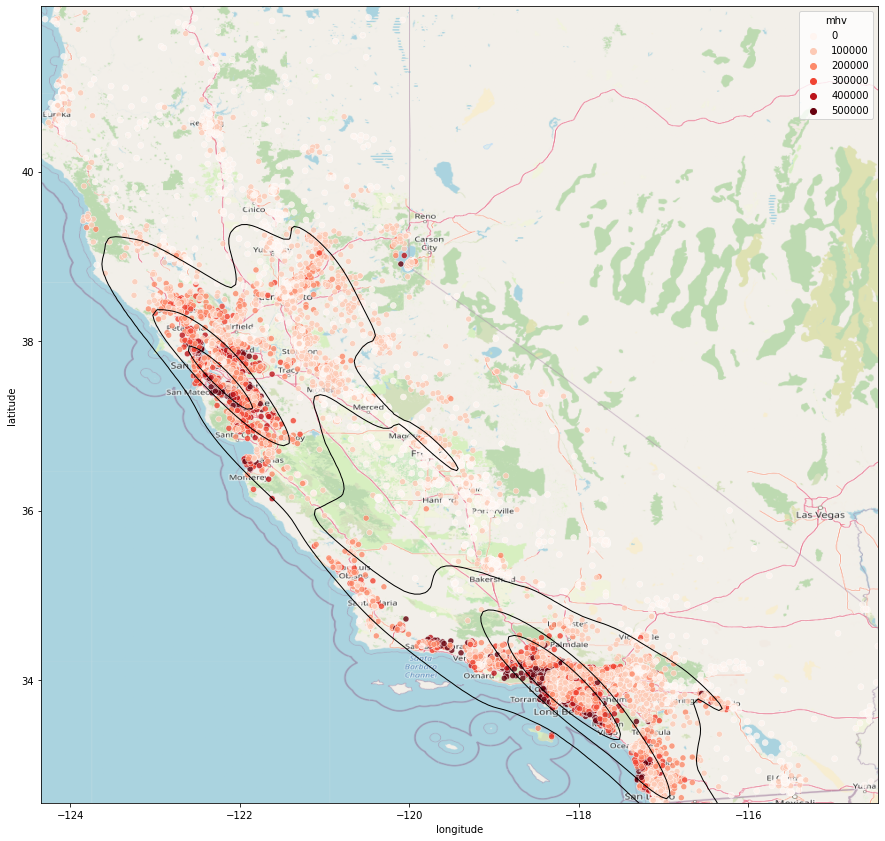

In [14]:
bgmap = plt.imread("img/lon-124.35,-114.47lat32.55,41.95.0946x1134.png")
BBox = (
    cali.longitude.min(),
    cali.longitude.max(),
    cali.latitude.min(),
    cali.latitude.max(),
)

fig, ax = plt.subplots(figsize=(15, 15))
ax.set(xlim=BBox[:2], ylim=BBox[2:])
sns.color_palette("Reds", as_cmap=True)
sns.scatterplot(
    data=cali,
    x="longitude",
    y="latitude",
    hue="mhv",
    zorder=1,
    alpha=0.8,
    ax=ax,
    palette="Reds",
)
sns.kdeplot(
    data=cali,
    x="longitude",
    y="latitude",
    weights="mhv",
    levels=4,
    color="black",
    linewidths=1,
)
ax.imshow(bgmap, zorder=0, extent=BBox, aspect="equal")

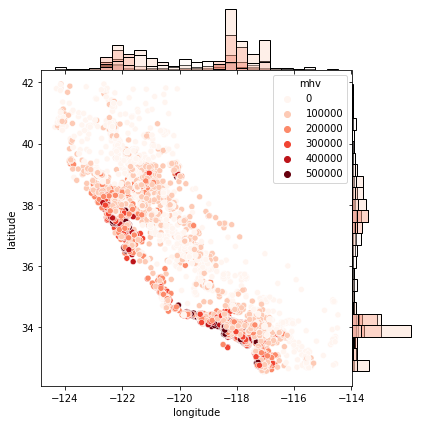

In [17]:
# fig, ax = plt.subplots(figsize=(15, 15))
g = sns.JointGrid(
    data=cali,
    x="longitude",
    y="latitude",
    hue="mhv",
    space=0,
    palette="Reds",
)
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.histplot, alpha=0.3, bins=25)  # , kde=True)

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>],
       [<AxesSubplot:title={'center':'mhv'}>,
        <AxesSubplot:title={'center':'mean_rooms_per_household'}>,
        <AxesSubplot:title={'center':'mean_people_per_household'}>]],
      dtype=object)

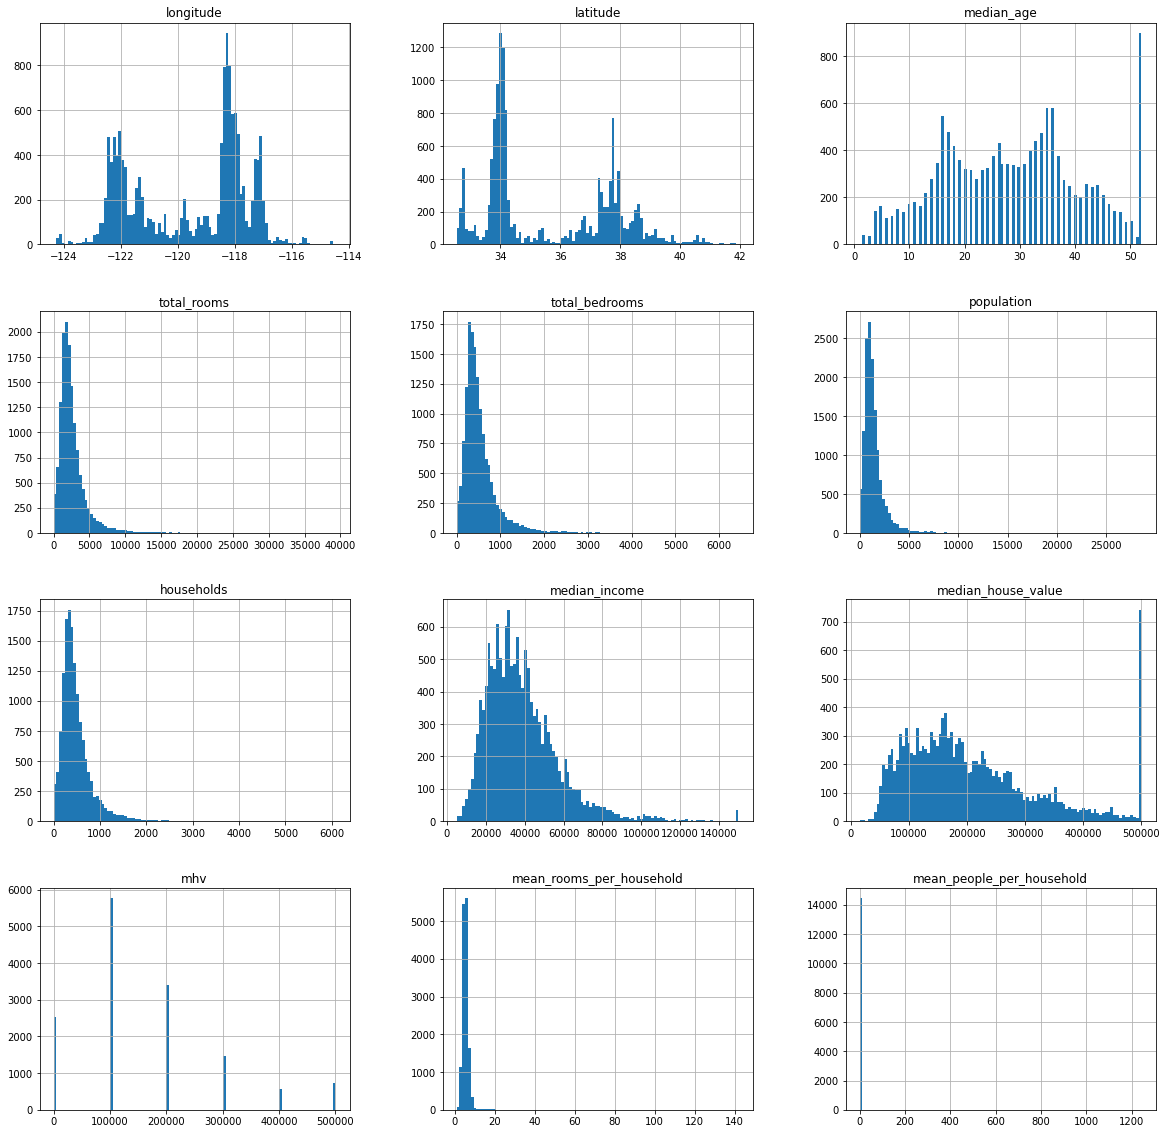

In [19]:
cali.hist(bins=100, figsize=(20, 20))

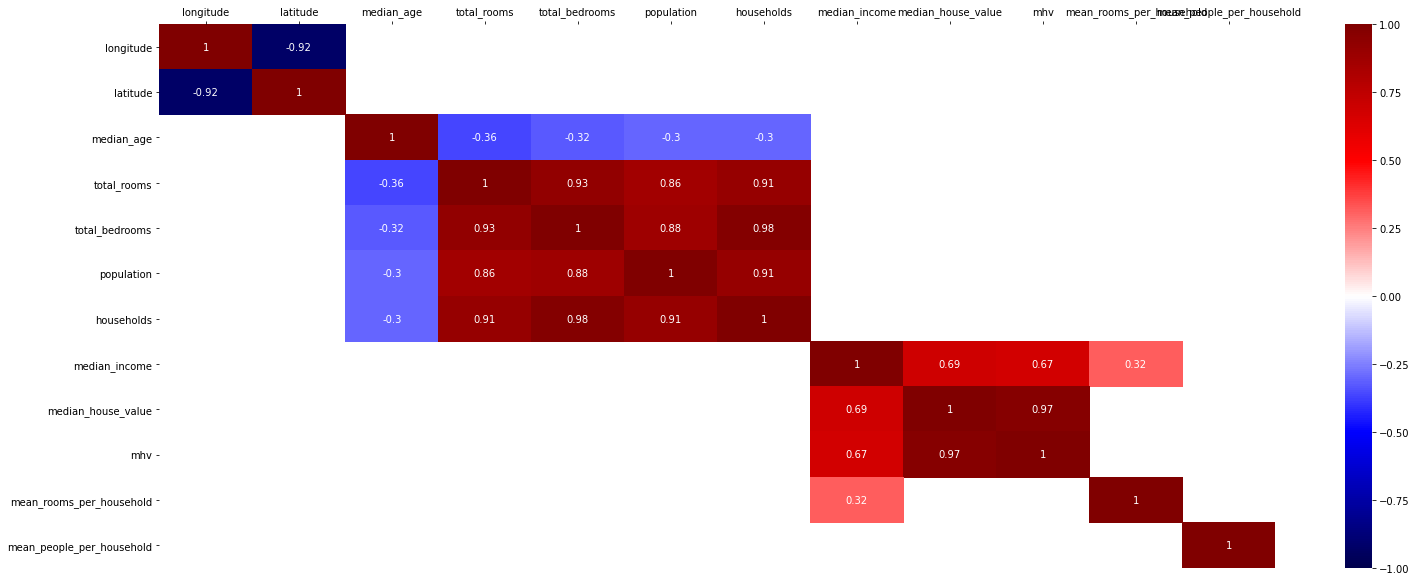

In [23]:
corrmat = cali.corr()
threshold = 0.3
plt.figure(figsize=(25, 10))
sns.heatmap(
    corrmat[abs(corrmat[:]) > threshold],
    vmax=1.0,
    vmin=-1.0,
    annot=True,
    cmap="seismic",
).xaxis.tick_top()

<Figure size 1440x1440 with 0 Axes>

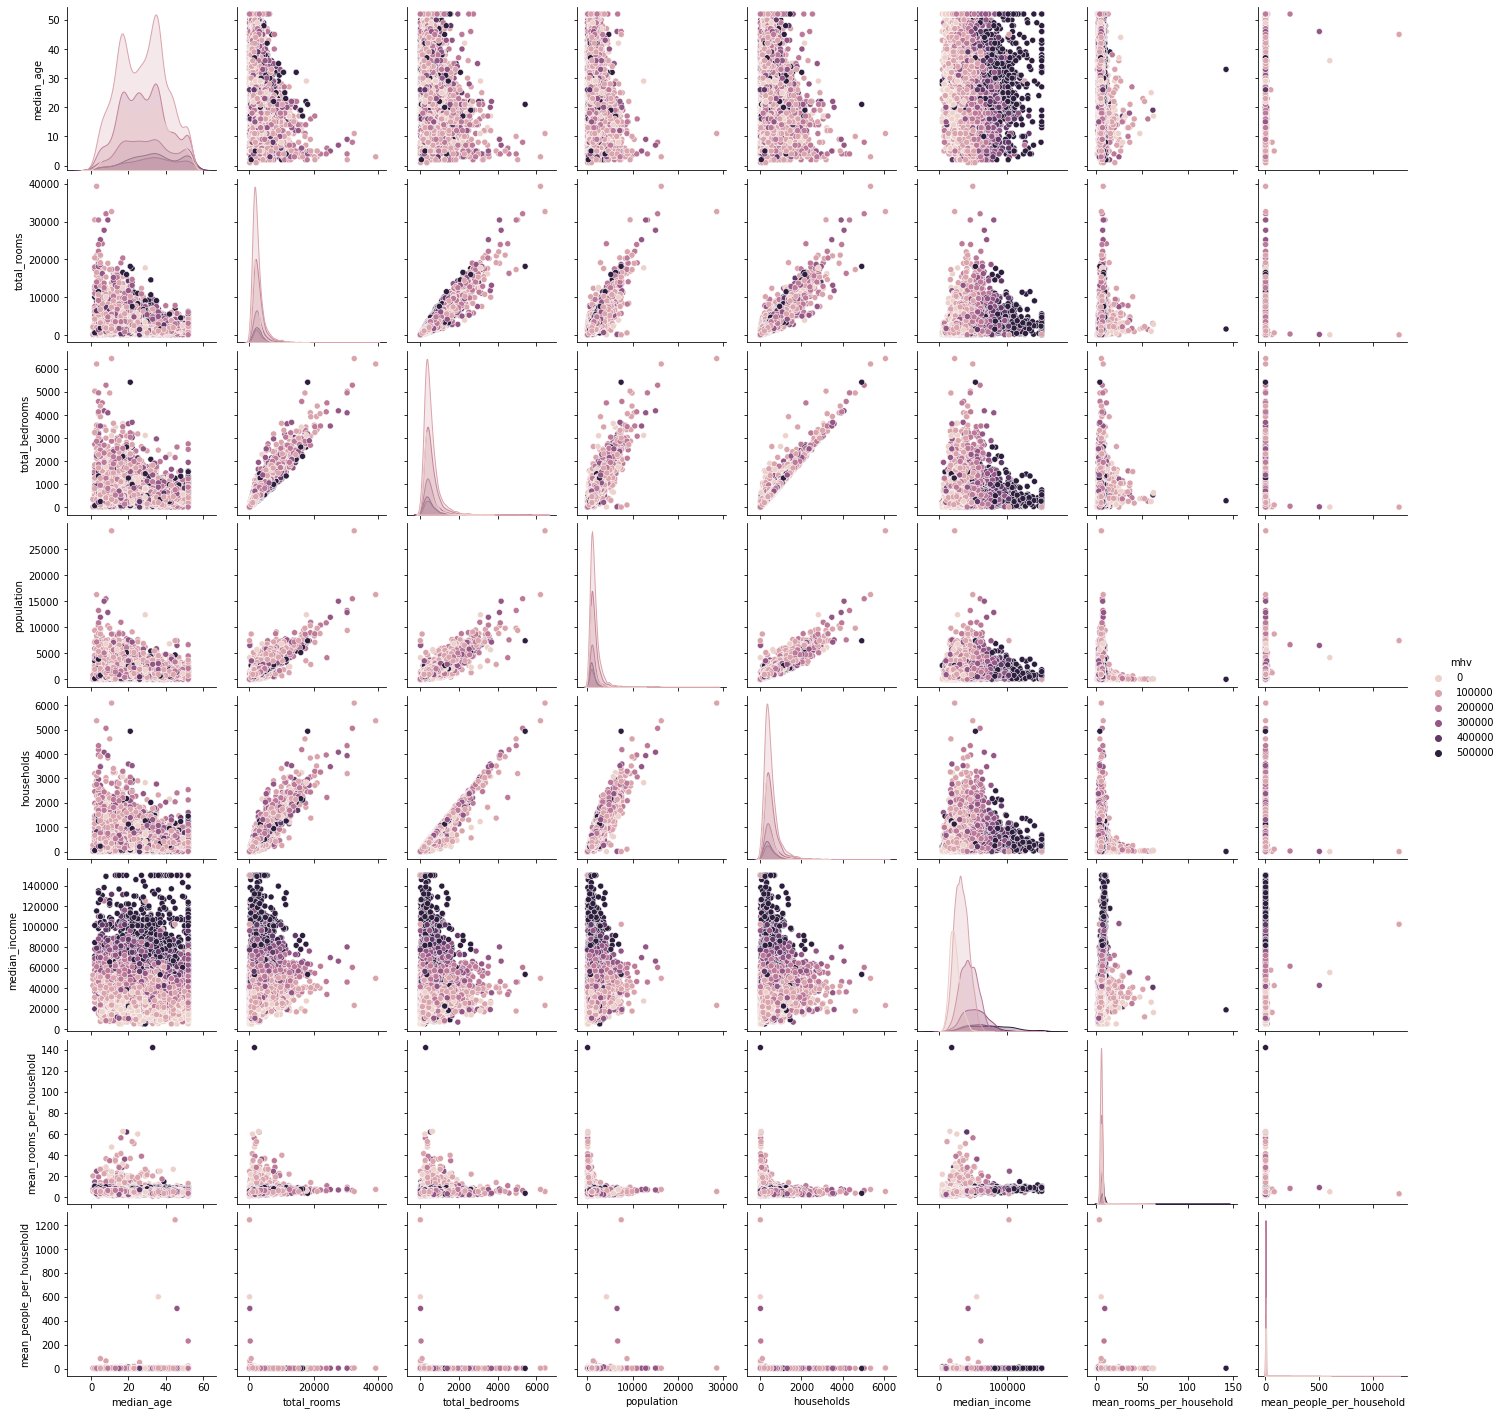

In [25]:
plt.figure(figsize=(20, 20))
sns.pairplot(
    cali,
    vars=[
        "median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income",
        "mean_rooms_per_household",
        "mean_people_per_household",
    ],
    hue="mhv",
)